Test demo case

In [59]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
from scipy.ndimage import zoom

from skimage.restoration import inpaint
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import ListedColormap
from scipy.ndimage import binary_dilation
from scipy.ndimage import distance_transform_edt
import matplotlib.patches as mpatches
from matplotlib.path import Path
from matplotlib import ticker

import sys
sys.path.insert(0, r'E:\karaouli\Projects\00python\gridder')
sys.path.insert(0, r'E:\karaouli\Projects\00python\geo_vtk\src')

#sys.path.insert(0, r'/Users/marios/OneDrive - Αριστοτέλειο Πανεπιστήμιο Θεσσαλονίκης/python/gridder')
#sys.path.insert(0, r'/Users/marios/OneDrive - Αριστοτέλειο Πανεπιστήμιο Θεσσαλονίκης/python/geo_vtk/src')

from gridder import Geo_Gridder
from vtkclass import VtkClass

# This notebook is prepared for upload to GitHub.
# All dependencies are imported above.
# Please ensure that any local paths (e.g., sys.path.insert) are updated or documented for portability.
# Data files required for execution (e.g., .npy, .gpkg, .txt) should be included or referenced in the repository's README.
# For reproducibility, consider adding requirements.txt or environment.yml with all necessary packages.

In [2]:

def distance(x, y, x0, y0):
    """
    Return distance between point
    P[x0,y0] and a curve (x,y)
    """
    d_x = x - x0
    d_y = y - y0
    dis = np.sqrt( d_x**2 + d_y**2 )
    return dis

def min_distance(x, y, x0, y0,precision=5):
    """
    Compute minimum/a distance/s between
    a point P[x0,y0] and a curve (x,y)
    rounded at `precision`.
    
    ARGS:
        x, y      (array)
        P         (tuple)
        precision (int)
        
    Returns min indexes and distances array.
    """
    # compute distance
    d = distance(x, y,x0, y0)
    d = np.round(d, precision)
    # find the minima
    glob_min_idxs = np.argwhere(d==np.min(d)).ravel()
    return glob_min_idxs, d





def onclick(event):
   print([event.xdata, event.ydata])

def arclength(x, y, a, b):
    """
    Computes the arclength of the given curve
    defined by (x0, y0), (x1, y1) ... (xn, yn)
    over the provided bounds, `a` and `b`.

    Parameters
    ----------
    x: numpy.ndarray
        The array of x values

    y: numpy.ndarray
        The array of y values corresponding to each value of x

    a: int
        The lower limit to integrate from

    b: int
        The upper limit to integrate to

    Returns
    -------
    numpy.float64
        The arclength of the curve

    """
    bounds = (x >= a) & (x <= b)
    # print(bounds)
    return np.trapz((
        np.sqrt(
            1 + np.gradient(y[bounds], x[bounds])
        ) ** 2),
        x[bounds]
    )

In [3]:
map=np.array([[200,200,200], #anthropogenic
		[157,78,64], #peat
		[0,146,0], #clay
		[194,207,92], #silty clay
		[255,255,255], # nothing
		[255,255,0], # fine
		[243,225,6], # medium
		[231,195,22], #coarse
		[216,163,32], #gravel
		[95,95,255]]) # shells
map=map/255
my_map=ListedColormap(map,name='IMOD')

# Define labels globally so they are accessible from all functions
labels = np.array([
	'anthropogenic',
	'peat',
	'clay',
	'silty clay',
	'nothing',
	'fine sand',
	'medium sand',
	'coarse sand',
	'gravel',
	'shells'
])

In [4]:
from matplotlib import rcParams

def plot_model(basis, del1, del_perc=None, cmap='viridis',filename='model.pdf'):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=False)

    # First subplot
    im1 = axes[0].imshow(basis, cmap=cmap, vmin=0, vmax=9)
    axes[0].set_ylabel('Depth (m)')
    axes[0].set_title('Given boreholes')
    axes[0].set_xlabel('Distance (m)')
    axes[0].set_xlim(-0.5-2, basis.shape[1] - 0.5 + 2)

    # Second subplot
    if del_perc is None:
        uncertainty = 1 - np.abs(del1 - 0.5) * 2
        uncertainty_percent = uncertainty * 100
    else:
        uncertainty_percent = del_perc

    im2 = axes[1].imshow(uncertainty_percent, cmap='gist_gray', vmin=0, vmax=100)
    axes[1].set_title('% Uncertainty')
    axes[1].set_xlabel('Distance (m)')
    cbar = plt.colorbar(im2, ax=axes[1], orientation='horizontal', pad=0.2, fraction=0.046)
    cbar.set_label('% Error')

    # Third subplot
    im3 = axes[2].imshow(np.round(del1), cmap=cmap, vmin=0, vmax=9)
    axes[2].set_title('Reconstructed model')
    axes[2].set_xlabel('Distance (m)')
    unique_values = np.unique(basis.ravel()[~np.isnan(basis.ravel())])
    cmap_obj = im1.get_cmap()
    norm = im1.norm
    legend_handles = []
    for idx, value in enumerate(unique_values):
        color = cmap_obj(norm(value))
        if int(value) < len(labels):
            label = labels[int(value)]
        else:
            label = f'Unit {value}'
        patch = mpatches.Patch(color=color, label=label)
        legend_handles.append(patch)

    # Place legend below the axis label
    axes[0].legend(
        handles=legend_handles,
        title="Legend",
        loc='upper center',
        bbox_to_anchor=(0.5, -0.55),  # Move further down
        ncol=len(unique_values)
    )

    # Align subplots on the top side
    for ax in axes:
        ax.set_anchor('N')

    plt.subplots_adjust(wspace=0.15)
    rcParams['pdf.fonttype'] = 42  # Ensures fonts are embedded as TrueType
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.show()


In [5]:
def plot_model_with_validation(real, basis, del1, del_perc=None, cmap='viridis', random_indices=None):
    fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
    del1 = del1.copy()
    del1[np.isnan(real)] = np.nan

    # First subplot
    im1 = axes[0][0].imshow(basis, cmap=cmap, vmin=0, vmax=9)
    axes[0][0].set_ylabel('Depth (cm)')
    axes[0][0].set_title('All boreholes')
    axes[0][0].set_xlim(-0.5-2, basis.shape[1] - 0.5 + 2)

    # Second subplot
    if del_perc is None:
        uncertainty = 1 - np.abs(del1 - 0.5) * 2
        uncertainty_percent = uncertainty * 100
    else:
        uncertainty_percent = del_perc

    im2 = axes[0][1].imshow(uncertainty_percent, cmap='gist_gray', vmin=0, vmax=100)
    axes[0][1].set_title('% Uncertainty')
    axes[0][1].set_xlabel('Distance (m)')
    axes[0][1].set_xlim(-0.5-2, basis.shape[1] - 0.5 + 2)
    cbar = fig.colorbar(im2, ax=axes[0][1], orientation='vertical', pad=0.02, fraction=0.046)
    cbar.set_label('% Error')

    # Third subplot
    axes[0][2].imshow(np.round(del1), cmap=cmap, vmin=0, vmax=9)
    axes[0][2].set_title('Reconstructed model')
    unique_values = np.unique(basis.ravel()[~np.isnan(basis.ravel())])

    cmap_obj = im1.get_cmap()
    norm = im1.norm
    legend_handles = []
    for idx, value in enumerate(unique_values):
        color = cmap_obj(norm(value))
        if int(value) < len(labels):
            label = labels[int(value)]
        else:
            label = f'Unit {value}'
        patch = mpatches.Patch(color=color, label=label)
        legend_handles.append(patch)

    axes[0][0].legend(handles=legend_handles, title="Legend",
                      loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1, frameon=True)

    # Fourth subplot
    axes[1][0].imshow(np.round(real), cmap=cmap, vmin=0, vmax=9)
    axes[1][0].set_title('Real model')

    # Validation/confusion matrix
    if random_indices is None:
        random_indices = np.arange(real.shape[1])
    test_data = real[:, random_indices].ravel()
    pred_data = del1[:, random_indices].ravel()
    i_keep = np.where(np.isfinite(test_data))[0]
    confusion_matrix = metrics.confusion_matrix(test_data[i_keep], pred_data[i_keep])
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm_display.plot(ax=axes[1][1], cmap=plt.cm.Blues, xticks_rotation=45, colorbar=False)
    axes[1][1].set_title('Confusion Matrix')

    tick_labels = [h.get_label() for h in legend_handles]
    axes[1][1].set_xticks(np.arange(len(tick_labels)))
    axes[1][1].set_yticks(np.arange(len(tick_labels)))
    axes[1][1].set_xticklabels(tick_labels, rotation=45, ha='right')
    axes[1][1].set_yticklabels(tick_labels)

    # Hide unused subplot
    axes[1][2].axis('off')
    diff_binary = (np.round(real) != np.round(del1)).astype(int)
    axes[1][2].imshow(diff_binary, cmap='gray', vmin=0, vmax=1)
    axes[1][2].set_title('Binary Difference Mask')

    #plt.tight_layout()
    plt.show()


In [6]:

def plot_model_with_validation_real(real, basis, del1, X, Y, tt, del_perc=None, cmap='viridis', random_indices=None,filename='model_with_validation.pdf'):

    # Prepare polygon mask for topography
    polygon = tt.T
    points = np.c_[X.ravel(), Y.ravel()]
    poly_path = Path(polygon)
    inside = poly_path.contains_points(points)
    inside_mask = inside.reshape(X.shape)
    del1_plot = del1.copy()
    del1_plot[~inside_mask] = np.nan
    if del_perc is not None:
        del_perc = del_perc.copy()
        del_perc[~inside_mask] = np.nan

    unique_values = np.unique(basis.ravel()[~np.isnan(basis.ravel())])

    # Validation/confusion matrix
    if random_indices is None:
        random_indices = np.arange(real.shape[1])
    test_data = real[:, random_indices].ravel()
    test_data_plot = np.nan * np.ones_like(real)
    pred_data_plot = np.nan * np.ones_like(real)
    test_data_plot[:, random_indices] = real[:, random_indices]
    pred_data_plot[:, random_indices] = del1_plot[:, random_indices]
    pred_data = del1[:, random_indices].ravel()
    i_keep = np.where(np.isfinite(test_data))[0]

    # Set global style
    plt.rcParams.update({'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 16})

    fig, axes = plt.subplots(4, 1, figsize=(18, 24), constrained_layout=True)

    # Calculate common x-limits (min/max) for all subplots
    x_min = np.nanmin(X)
    x_max = np.nanmax(X)

    # Plot 1: All boreholes and validation
    im1 = axes[0].pcolor(X + 25, Y - 0.125, np.round(real), cmap=cmap, vmin=0, vmax=9, edgecolors='w', linewidths=1.0, shading='auto')
    axes[0].pcolor(X + 25, Y - 0.125, np.round(test_data_plot), cmap=cmap, vmin=0, vmax=9, edgecolors='k', linewidths=1.0, shading='auto')
    axes[0].set_ylabel('Elevation (m)')
    axes[0].set_title('Boreholes used for inpainting - Boreholes used for validation')
    axes[0].set_aspect('auto')
    axes[0].set_xlim(x_min, x_max)
    axes[0].grid(True, linestyle='--', alpha=0.5)
    cmap_obj = im1.get_cmap()
    norm = im1.norm
    legend_handles = []
    for idx, value in enumerate(unique_values):
        color = cmap_obj(norm(value))
        label = labels[int(value)] if int(value) < len(labels) else f'Unit {value}'
        patch = mpatches.Patch(color=color, label=label)
        legend_handles.append(patch)
    axes[0].legend(handles=legend_handles, title="Legend", loc='upper left', bbox_to_anchor=(1.01, 1), ncol=1, frameon=True)

    # Plot 2: Validation vs Prediction
    axes[1].pcolor(X + 50, Y - 0.125, np.round(test_data_plot), cmap=cmap, vmin=0, vmax=9, edgecolors='k', linewidths=1.0, shading='auto')
    axes[1].pcolor(X + 25, Y - 0.125, np.round(pred_data_plot), cmap=cmap, vmin=0, vmax=9, edgecolors='r', linewidths=1.0, shading='auto')
    axes[1].set_ylabel('Elevation (m)')
    axes[1].set_title('Validation boreholes - Predicted boreholes')
    axes[1].set_aspect('auto')
    axes[1].grid(True, linestyle='--', alpha=0.5)
    # Add legend for validation and prediction
    red_patch = mpatches.Patch(edgecolor='r', facecolor='none', linewidth=2, label='Prediction')
    black_patch = mpatches.Patch(edgecolor='k', facecolor='none', linewidth=2, label='Validation')
    axes[1].legend(handles=[red_patch, black_patch], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=True)

    # Plot 3: Reconstructed model
    axes[2].pcolor(X, Y, np.round(del1_plot), cmap=cmap, vmin=0, vmax=9, edgecolors='w', linewidths=0.5, shading='auto')
    axes[2].set_title('Reconstructed model')
    axes[2].pcolor(X + 25, Y - 0.125, np.round(real), cmap=cmap, vmin=0, vmax=9, edgecolors='b', linewidths=0.5, shading='auto')
    axes[2].pcolor(X + 25, Y - 0.125, np.round(pred_data_plot), cmap=cmap, vmin=0, vmax=9, edgecolors='r', linewidths=1.0, shading='auto')

    axes[2].set_ylabel('Elevation (m)')
    axes[2].set_aspect('auto')
    axes[2].grid(True, linestyle='--', alpha=0.5)
    # Add legend for validation and prediction
    red_patch = mpatches.Patch(edgecolor='b', facecolor='none', linewidth=2, label='Data Used')
    black_patch = mpatches.Patch(edgecolor='r', facecolor='none', linewidth=2, label='Prediction')
    axes[2].legend(handles=[red_patch, black_patch], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=True)


    # Plot 4: Uncertainty
    im2 = axes[3].pcolor(X, Y, del_perc, cmap='gist_gray', vmin=0, vmax=100, shading='auto')
    axes[3].set_title('% Uncertainty')
    axes[3].set_ylabel('Elevation (m)')
    axes[3].set_xlabel('Distance (m)')
    axes[3].set_aspect('auto')
    axes[3].grid(True, linestyle='--', alpha=0.5)
    cbar = fig.colorbar(im2, ax=axes[3], orientation='vertical', pad=0.02, fraction=0.04)
    cbar.set_label('% Error')
    cbar.ax.tick_params(labelsize=12)
    rcParams['pdf.fonttype'] = 42  # Ensures fonts are embedded as TrueType
    fig.savefig(filename, format="pdf", bbox_inches="tight")
    # Confusion Matrix (only classes present in true or predicted labels)
    present_true = np.unique(test_data[i_keep])
    present_pred = np.unique(pred_data[i_keep])
    present_classes = np.unique(np.concatenate([present_true, present_pred]))
    # Remove nan and zero if not present
    present_classes = present_classes[np.isfinite(present_classes)]
    # Only keep classes with at least one true or predicted sample
    mask_present = np.isin(test_data[i_keep], present_classes) | np.isin(pred_data[i_keep], present_classes)
    # Get corresponding labels
    present_labels = [labels[int(c)] if int(c) < len(labels) else f'Unit {c}' for c in present_classes]
    fig_cm, ax_cm = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
    confusion_matrix = metrics.confusion_matrix(
        test_data[i_keep][mask_present], 
        pred_data[i_keep][mask_present], 
        labels=present_classes
    )
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm_display.plot(ax=ax_cm, cmap=plt.cm.Blues, xticks_rotation=45, colorbar=False)
    ax_cm.set_title('Confusion Matrix (Present Classes)', fontsize=18)
    ax_cm.set_xticks(np.arange(len(present_labels)))
    ax_cm.set_yticks(np.arange(len(present_labels)))
    ax_cm.set_xticklabels(present_labels, rotation=45, ha='right', fontsize=14)
    ax_cm.set_yticklabels(present_labels, fontsize=14)
    ax_cm.grid(False)
    fig_cm.savefig(filename[:-4]+'_validation.pdf', format="pdf", bbox_inches="tight")
    plt.show()


In [7]:
def plot_confusion_matrix(y_true, y_pred, labels=None, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plots a confusion matrix.
    
    Parameters:
    - y_true: true labels
    - y_pred: predicted labels
    - labels: list of class names
    - title: title of the plot
    - cmap: colormap for the matrix
    """
    fig_cm, ax_cm = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm_display.plot(ax=ax_cm, cmap=plt.cm.Blues, xticks_rotation=45, colorbar=False)
    ax_cm.set_title('Confusion Matrix', fontsize=18)
    ax_cm.set_xticks(np.arange(len(labels)))
    ax_cm.set_yticks(np.arange(len(labels)))
    ax_cm.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)
    ax_cm.set_yticklabels(labels, fontsize=14)
    ax_cm.grid(False)
    plt.show()
    rcParams['pdf.fonttype'] = 42  # Ensures fonts are embedded as TrueType
    fig_cm.savefig("confusion_matrix.pdf", format="pdf", bbox_inches="tight")

In [8]:
def make_mask(basis):
    mask = np.ones_like(basis)
    mask[np.isfinite(basis)] = 0
    #plt.imshow(mask)
    return mask 

In [9]:
def weighted_inpaint_biharmonic(image, mask, x_weight=1.0, y_weight=1.0):
    image[np.isnan(image)] = 0  # Replace NaNs with zeros for inpainting
    #mask = make_mask(image)  # Create a mask where the image is NaN
    # Compute zoom factors (inverse of weights)
    zoom_factors = [y_weight, x_weight]
    # Rescale image and mask
    image_scaled = zoom(image, zoom_factors, order=1)
    mask_scaled = zoom(mask, zoom_factors, order=0)
    # Inpaint on the scaled image
    inpainted_scaled = inpaint.inpaint_biharmonic(image_scaled, mask_scaled, channel_axis=None)
    # Rescale back to original shape
    inpainted = zoom(inpainted_scaled, [1/y_weight, 1/x_weight], order=1)
    # Crop to original shape (in case of rounding)
    inpainted = inpainted[:image.shape[0], :image.shape[1]]
    return inpainted

In [10]:
def weighted_inpaint_biharmonic_3d(image, mask, x_weight=1.0, y_weight=1.0, z_weight=1.0):
    image[np.isnan(image)] = 0  # Replace NaNs with zeros for inpainting
    
    # Compute zoom factors (inverse of weights)
    zoom_factors = [z_weight, y_weight, x_weight]
    
    # Rescale image and mask
    image_scaled = zoom(image, zoom_factors, order=1)
    mask_scaled = zoom(mask, zoom_factors, order=0)
    
    # Inpaint on the scaled image
    inpainted_scaled = inpaint.inpaint_biharmonic(image_scaled, mask_scaled, channel_axis=None)
    
    # Rescale back to original shape
    inpainted = zoom(inpainted_scaled, [1/z_weight, 1/y_weight, 1/x_weight], order=1)
    
    # Crop to original shape (in case of rounding)
    inpainted = inpainted[:image.shape[0], :image.shape[1], :image.shape[2]]
    
    return inpainted

In [11]:
def one_vs_all(image, x_weight=1.0, y_weight=3.0):
    # find here unique labels in the image
    uni_class=np.unique(image.ravel()[~np.isnan(image.ravel())])
    # for every unique label, create a mask and inpaint
    del2=np.zeros((image.shape[0],image.shape[1],len(uni_class)))
    for i, label in enumerate(uni_class):
        #make binary        
        ee = np.float64(np.where(image.copy() == label, 1, 0))

        del2[:,:,i] = weighted_inpaint_biharmonic(ee.copy(), make_mask(image), x_weight=x_weight, y_weight=y_weight)

    #normalize values
    del3=np.zeros_like(del2)
    tmp=np.sum(del2,axis=2)
    for i in range(0,del3.shape[2]):
        del3[:,:,i]=del2[:,:,i]/tmp
   
    
    del4=np.argmax(del3,axis=2)  

    #map back to actual classes
    inverse_value_map = {}
    for i, label in enumerate(uni_class):
        inverse_value_map[i] = label        
    vectorized_inverse_map = np.vectorize(inverse_value_map.get)
    del4 = vectorized_inverse_map(del4)
    # calculate percentage of uncertainty
    # del3 contains the probabilities for each class    
    del_perc=100-100*np.max(del3,axis=2) 

    return del4, del_perc

In [12]:
def one_vs_all_3d(image, x_weight=1.0, y_weight=1.0, z_weight=1.0):
    # find here unique labels in the image
    uni_class=np.unique(image.ravel()[~np.isnan(image.ravel())])
    # for every unique label, create a mask and inpaint
    del2=np.zeros((image.shape[0],image.shape[1],image.shape[2],len(uni_class)))
    for i, label in enumerate(uni_class):
        #make binary        
        ee = np.float64(np.where(image.copy() == label, 1, 0))

        del2[:,:,:,i] = weighted_inpaint_biharmonic_3d(ee.copy(), make_mask(image), x_weight=x_weight, y_weight=y_weight,z_weight=z_weight)

    #normalize values
    del3=np.zeros_like(del2)
    tmp=np.sum(del2,axis=3)
    for i in range(0,del3.shape[3]):
        del3[:,:,:,i]=del2[:,:,:,i]/tmp
   
    
    del4=np.argmax(del3,axis=3)  

    #map back to actual classes
    inverse_value_map = {}
    for i, label in enumerate(uni_class):
        inverse_value_map[i] = label        
    vectorized_inverse_map = np.vectorize(inverse_value_map.get)
    del4 = vectorized_inverse_map(del4)
    # calculate percentage of uncertainty
    # del3 contains the probabilities for each class    
    del_perc=100-100*np.max(del3,axis=3) 

    return del4, del_perc

In [13]:
nx = 20
ny = 60


Let's make horizontal layering

In [14]:
basis=np.nan*np.zeros((nx, ny))

basis[0:np.int32(nx/2),0]=2
basis[np.int32(nx/2):,0]=5

basis[0:np.int32(nx/2),-1]=2
basis[np.int32(nx/2):,-1]=5


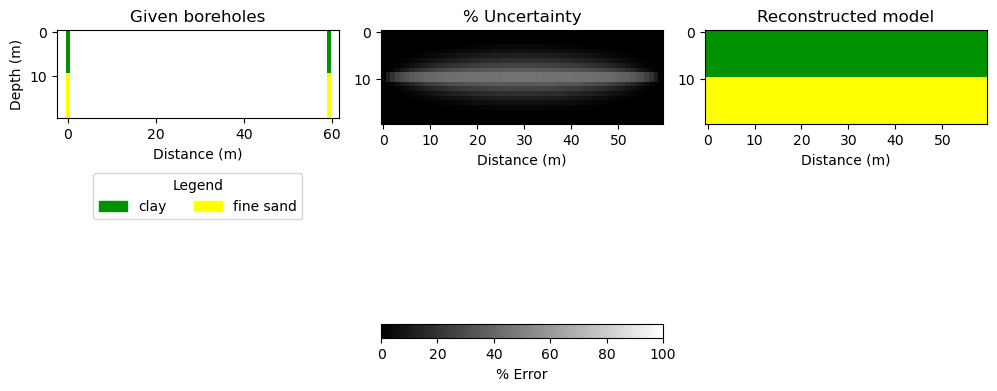

In [15]:
del2,del_perc = one_vs_all(basis)
plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model1.pdf')

Let's make smooth dipping

In [16]:
basis=np.nan*np.zeros((nx, ny))

basis[0:np.int32(nx/2),0]=2
basis[np.int32(nx/2):,0]=5

basis[0:np.int32(nx/2)+4,-1]=2
basis[np.int32(nx/2)+4:,-1]=5




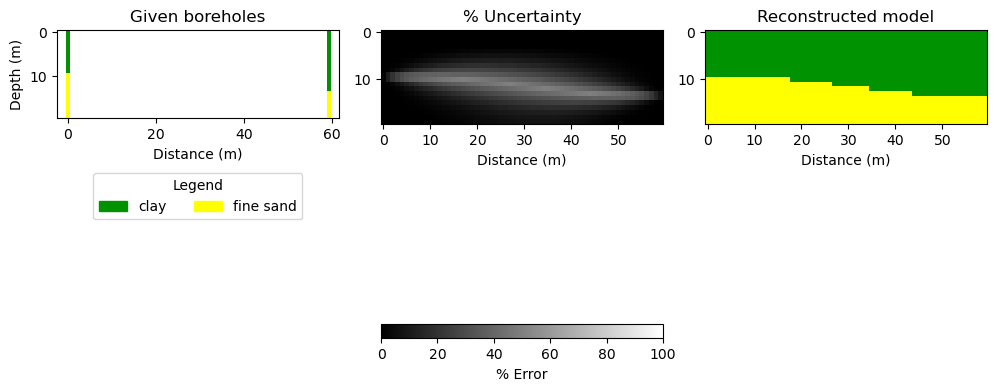

In [17]:
del2,del_perc = one_vs_all(basis)
plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model2.pdf')

Let's make a fault

In [18]:
basis=np.nan*np.zeros((nx, ny))

basis[0:3,0]=2
basis[3:,0]=5

basis[:nx-4,-1]=2
basis[nx-4:,-1]=5



Let's make layers that get thin

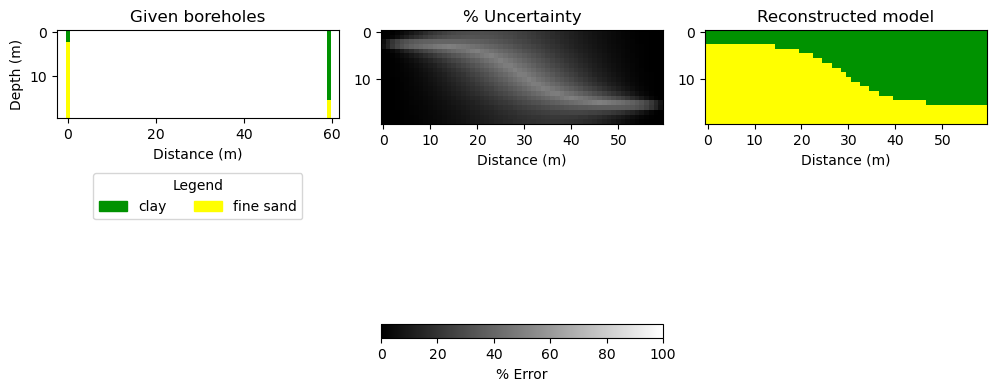

In [19]:
del2,del_perc = one_vs_all(basis)
plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model3.pdf')

In [20]:
basis=np.nan*np.zeros((nx, ny))

basis[0:4,0]=2
basis[4:14,0]=5
basis[14:,0]=2


basis[0:7,-1]=2
basis[7:12,-1]=5
basis[12:,-1]=2



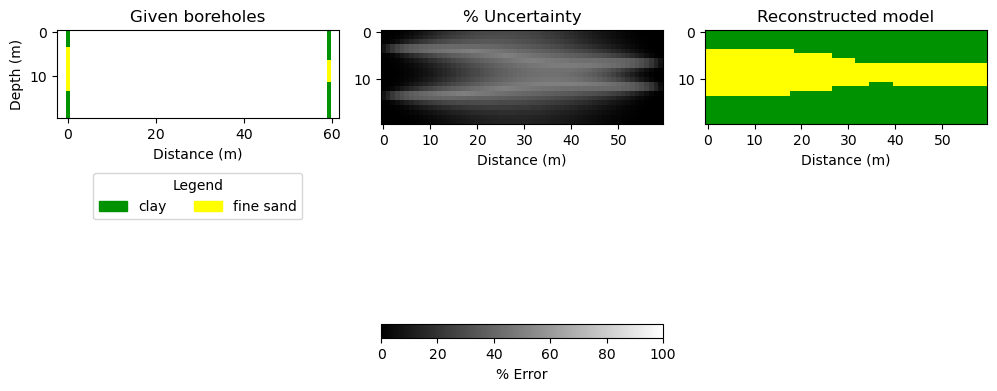

In [21]:
del2,del_perc = one_vs_all(basis)
plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model4.pdf')

In [22]:
basis=np.nan*np.zeros((nx, ny))

basis[0:4,0]=2
basis[4:14,0]=5
basis[14:,0]=2


basis[0:12,-1]=2
basis[12:18,-1]=5
basis[18:,-1]=2


4

4

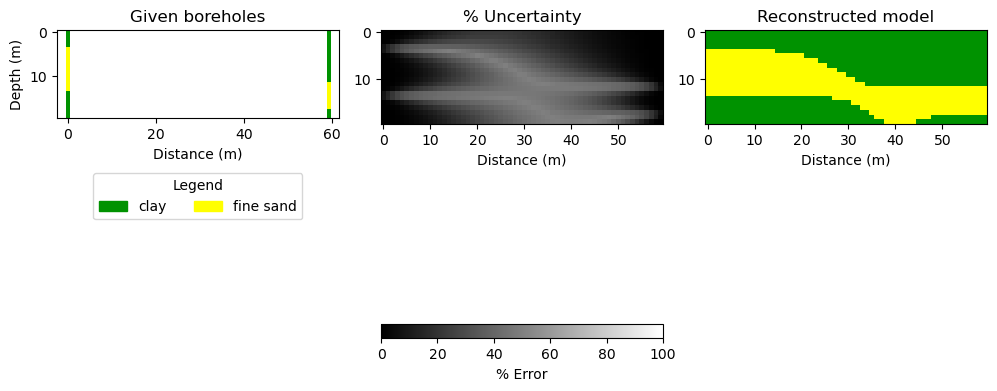

In [23]:
del2,del_perc = one_vs_all(basis)
plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model4a.pdf')

Same as above, but equal distance

In [24]:
basis=np.nan*np.zeros((nx, ny))

basis[0:4,0]=2
basis[4:14,0]=5
basis[14:,0]=2


basis[0:8,-1]=2
basis[8:18,-1]=5
basis[18:,-1]=2



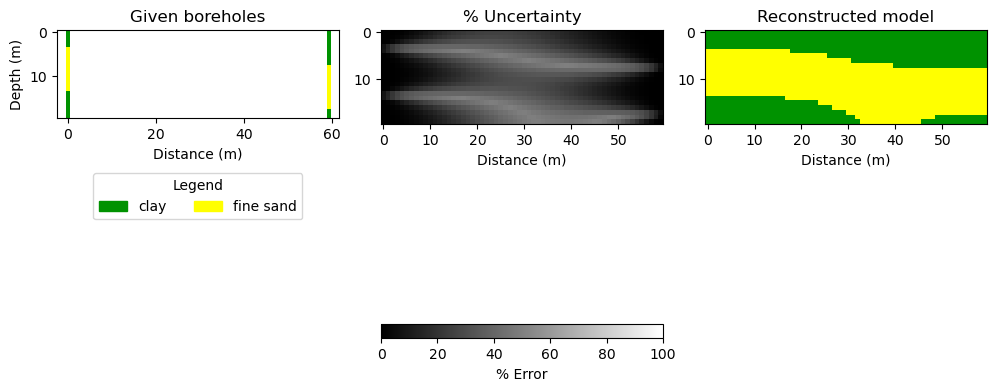

In [25]:
del2,del_perc = one_vs_all(basis)
plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model4b.pdf')

let's go to three boreholes

In [26]:
basis=np.nan*np.zeros((nx, ny))

basis[0:4,0]=2
basis[4:14,0]=5
basis[14:,0]=2


basis[0:8,np.int32(nx)]=2
basis[8:18,np.int32(nx)]=5
basis[18:,np.int32(nx)]=2

basis[0:4,-1]=2
basis[4:14,-1]=5
basis[14:,-1]=2



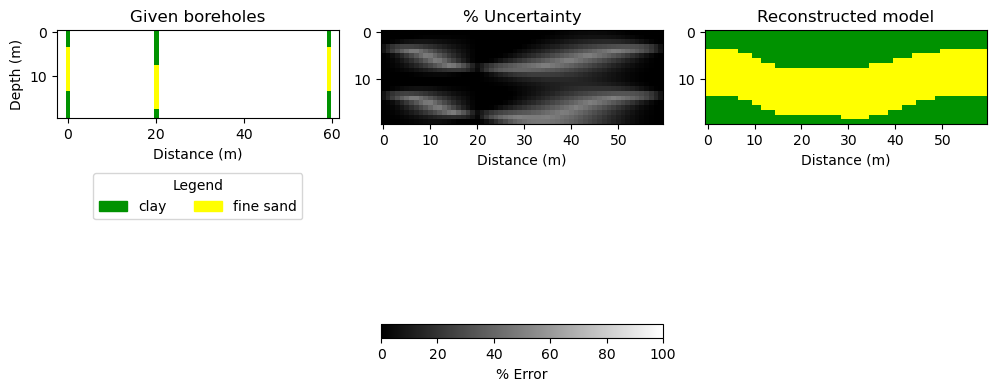

In [27]:
del2,del_perc = one_vs_all(basis)
plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model5.pdf')

Layer that get thicker and thicker

In [28]:
basis=np.nan*np.zeros((nx, ny))

basis[0:4,0]=2
basis[4:16,0]=5
basis[16:,0]=2


basis[0:6,np.int32(ny/2)]=2
basis[6:14,np.int32(ny/2)]=5
basis[14:,np.int32(ny/2)]=2

basis[0:7,-1]=2
basis[7:12,-1]=5
basis[12:,-1]=2



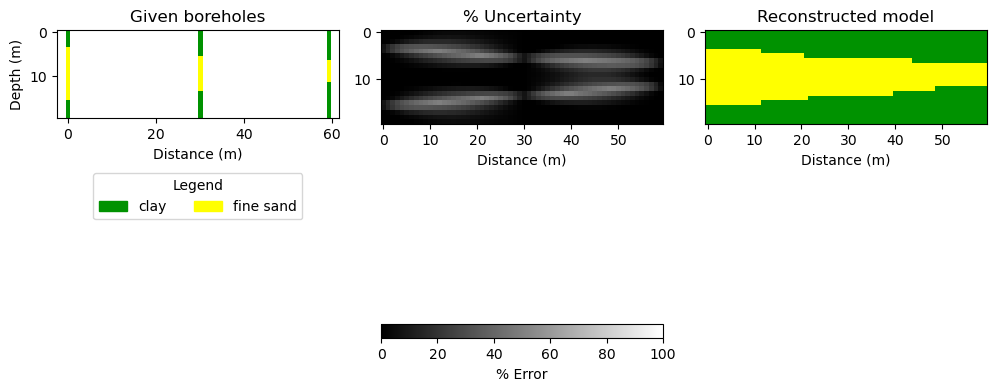

In [29]:
del2,del_perc = one_vs_all(basis)
plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model6.pdf')

let's try 3 layers

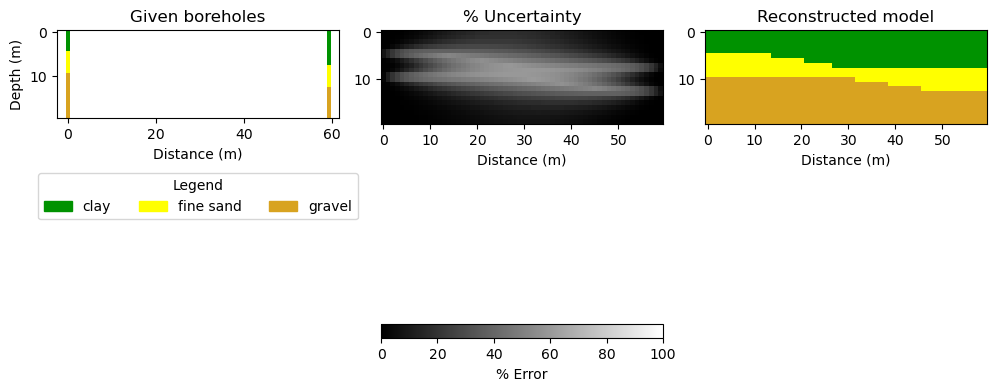

In [30]:
basis=np.nan*np.zeros((nx, ny))

basis[0:5,0]=2
basis[5:10,0]=5
basis[10:,0]=8

basis[0:8,-1]=2
basis[8:13,-1]=5
basis[13:,-1]=8

del2,del_perc = one_vs_all(basis)

plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model7.pdf')

make a fault

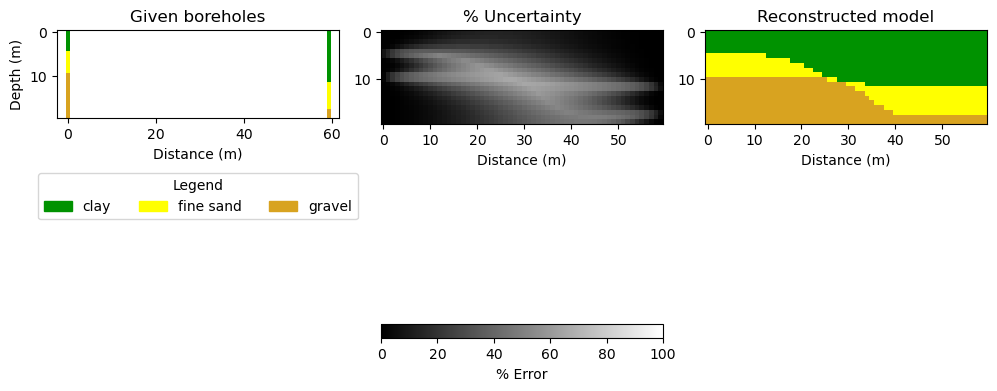

In [31]:

basis=np.nan*np.zeros((nx, ny))

basis[0:5,0]=2
basis[5:10,0]=5
basis[10:,0]=8

basis[0:12,-1]=2
basis[12:18,-1]=5
basis[18:,-1]=8

del2,del_perc = one_vs_all(basis, x_weight=1, y_weight=3)

plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model8_3.pdf')



Make some layer discontiniuos

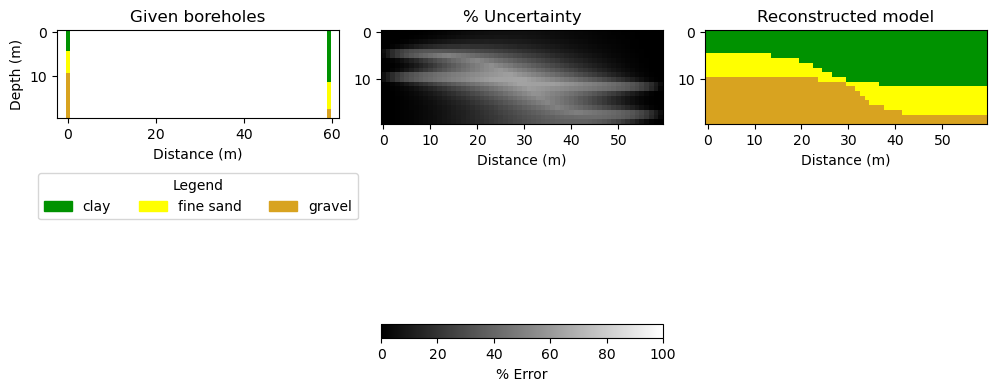

In [32]:
basis=np.nan*np.zeros((nx, ny))

basis[0:5,0]=2
basis[5:10,0]=5
basis[10:,0]=8

basis[0:12,-1]=2
basis[12:18,-1]=5
basis[18:,-1]=8

del2,del_perc = one_vs_all(basis, x_weight=1, y_weight=4)

plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model8_4.pdf')

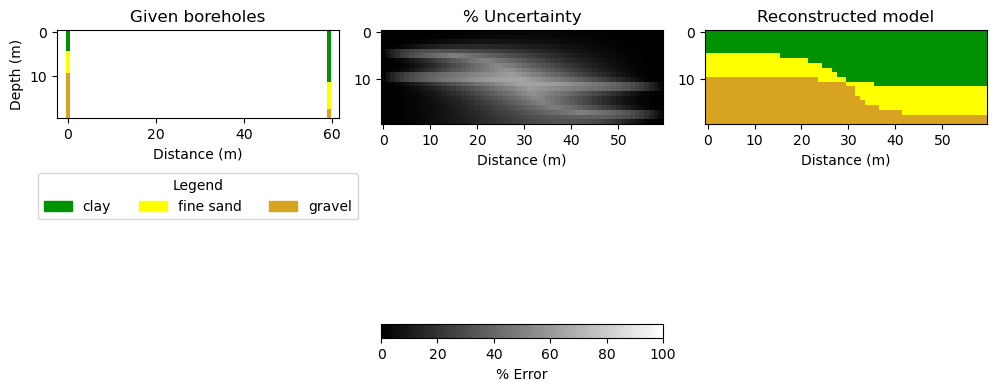

In [33]:
basis=np.nan*np.zeros((nx, ny))

basis[0:5,0]=2
basis[5:10,0]=5
basis[10:,0]=8

basis[0:12,-1]=2
basis[12:18,-1]=5
basis[18:,-1]=8

del2,del_perc = one_vs_all(basis, x_weight=1, y_weight=5)

plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model8_5.pdf')

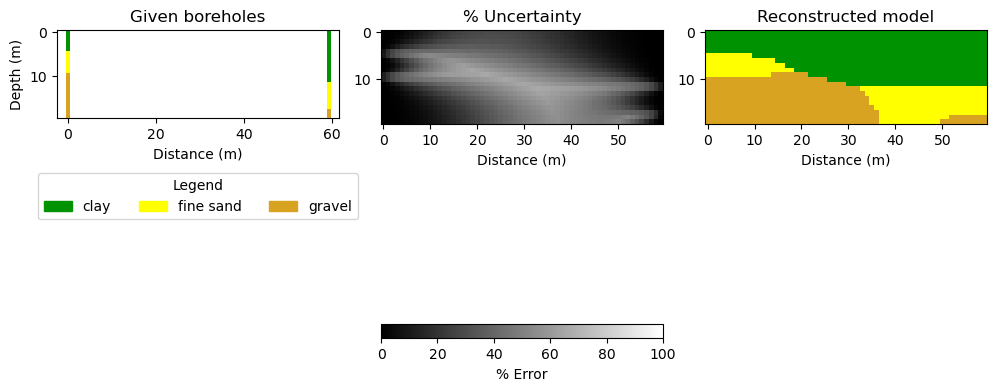

In [34]:
basis=np.nan*np.zeros((nx, ny))

basis[0:5,0]=2
basis[5:10,0]=5
basis[10:,0]=8

basis[0:12,-1]=2
basis[12:18,-1]=5
basis[18:,-1]=8

del2,del_perc = one_vs_all(basis, x_weight=1, y_weight=2)

plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model8_2.pdf')

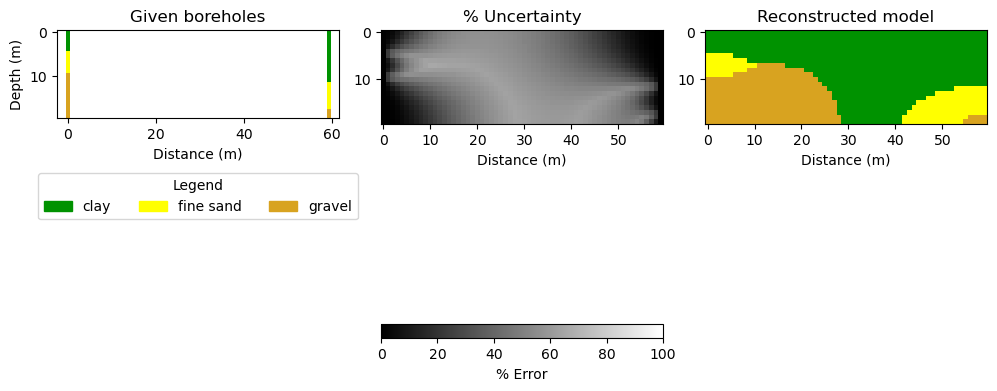

In [35]:
basis=np.nan*np.zeros((nx, ny))

basis[0:5,0]=2
basis[5:10,0]=5
basis[10:,0]=8

basis[0:12,-1]=2
basis[12:18,-1]=5
basis[18:,-1]=8

del2,del_perc = one_vs_all(basis, x_weight=1, y_weight=1)

plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model8_1.pdf')

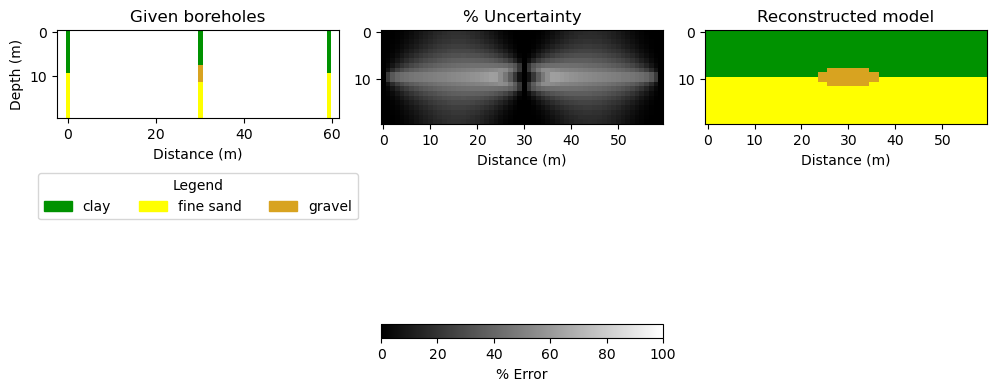

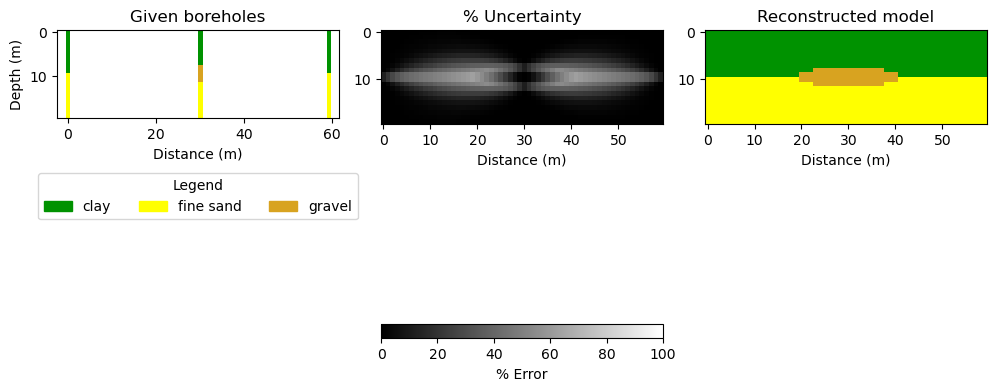

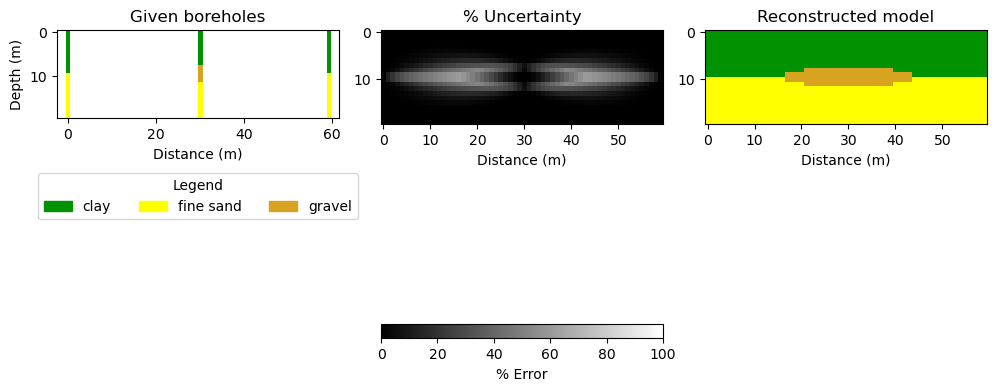

In [36]:
basis=np.nan*np.zeros((nx, ny))

basis[0:10,0]=2
basis[10:,0]=5


basis[0:10,np.int32(ny/2)]=2   
basis[12:,np.int32(ny/2)]=5
basis[8:12,np.int32(ny/2)]=8



basis[0:10,-1]=2
basis[10:,-1]=5


del2,del_perc = one_vs_all(basis, x_weight=1, y_weight=1)

plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model9_1.pdf')

del2,del_perc = one_vs_all(basis, x_weight=1, y_weight=2)

plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model9_2.pdf')

del2,del_perc = one_vs_all(basis, x_weight=1, y_weight=3)

plot_model(basis,del2,del_perc=del_perc,cmap=my_map,filename='model9_3.pdf')

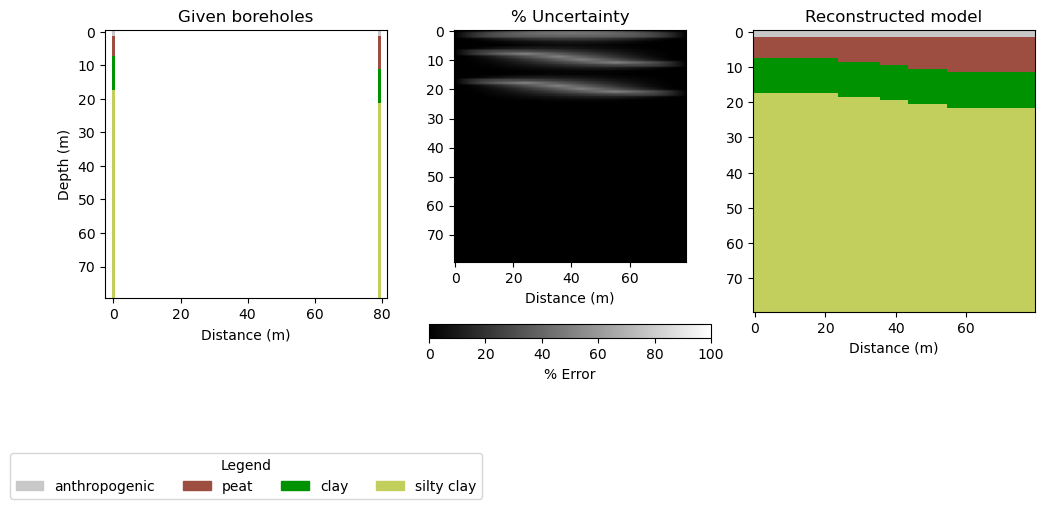

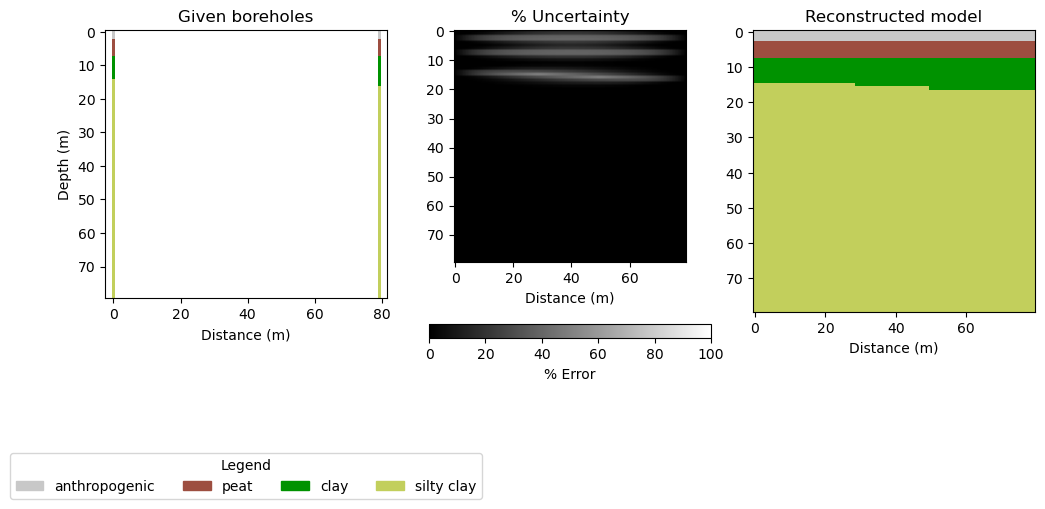

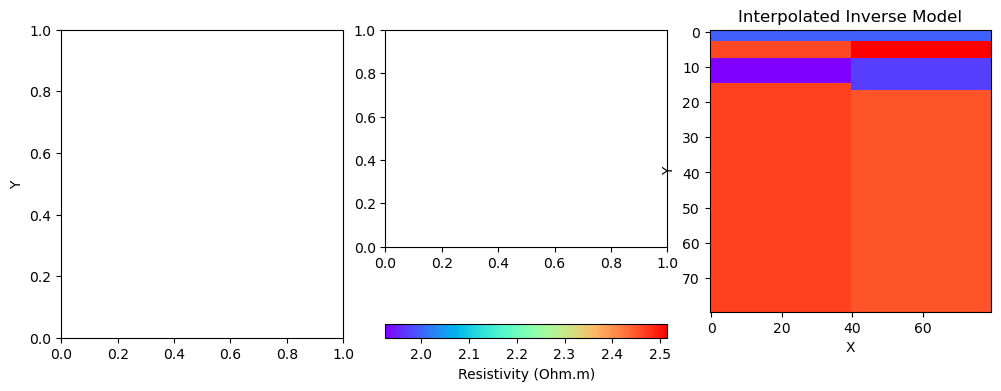

In [57]:
from scipy.interpolate import griddata

real_model = np.load('real_model.npy')
inv_model = np.load('inv_model.npy')
real_model_cat = np.load('real_model_cat.npy')
inv_model_cat = np.load('inv_model_cat.npy')




real_model_cat_resampled = zoom(real_model_cat, (80 / real_model_cat.shape[0], 80 / real_model_cat.shape[1]), order=0)
del2,del_perc = one_vs_all(real_model_cat_resampled, x_weight=1, y_weight=10)

plot_model(real_model_cat_resampled,del2,del_perc=del_perc,cmap=my_map,filename='ves_real.pdf')



inv_model_cat_resampled = zoom(inv_model_cat, (80 / inv_model_cat.shape[0], 80 / inv_model_cat.shape[1]), order=0)
del2,del_perc = one_vs_all(inv_model_cat_resampled, x_weight=1, y_weight=10)

plot_model(inv_model_cat_resampled,del2,del_perc=del_perc,cmap=my_map,filename='ves_inv.pdf')



# Perform 2D linear interpolation where there are NaNs in inv_model
inv_model_resampled = zoom(inv_model, (80 / inv_model.shape[0], 80 / inv_model.shape[1]), order=0)

inv_model_interp = inv_model_resampled.copy()
x = np.arange(inv_model_interp.shape[1])
y = np.arange(inv_model_interp.shape[0])
X, Y = np.meshgrid(x, y)


# Convert inv_model values to log10 before interpolation
# Mask valid points
valid_mask = np.isfinite(inv_model_interp)
inv_model_interp[valid_mask] = np.log10(inv_model_interp[valid_mask])

points = np.column_stack((X[valid_mask], Y[valid_mask]))
values = inv_model_interp[valid_mask]




# Interpolate only at NaN locations
nan_mask = ~valid_mask
inv_model_interp[nan_mask] = griddata(points,values, (X[nan_mask], Y[nan_mask]), method='nearest')

fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=False)

contour = axes[2].imshow(inv_model_interp, cmap='rainbow')
cbar = fig.colorbar(contour, ax=axes[1], orientation='horizontal', pad=0.25, fraction=0.046)
cbar.set_label('Resistivity (Ohm.m)')
axes[2].set_title('Interpolated Inverse Model')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
axes[0].set_ylabel('Y')

    # Align subplots on the top side
for ax in axes:
    ax.set_anchor('N')

plt.subplots_adjust(wspace=0.15)
rcParams['pdf.fonttype'] = 42  # Ensures fonts are embedded as TrueType
plt.savefig('interp.pdf', format='pdf', bbox_inches='tight')
plt.show()

Let's g8 to the good stuff (validation)

In [38]:
sss

NameError: name 'sss' is not defined

In [ ]:
geotop=np.load('geotop.npy')


demo=geotop[20,:,:].T
#demo=np.flipud(demo)
top=np.zeros((demo.shape[1]))
for i in range(0,demo.shape[1]):
    ix=np.where(np.isnan(demo[:,i]))[0][0]
    top[i]=ix

demo=demo[:np.max(top).astype('int32'),:]    
demo=np.flipud(demo)



In [ ]:
# Assume demo is already defined
total_samples = int(0.8 * demo.shape[1])  # Define the total number of samples

# Create a set of possible indices excluding 0 and demo.shape[1] - 1
possible_indices = list(range(1, demo.shape[1] - 1))

# Use np.random.choice to select samples without replacement
random_indices = np.random.choice(possible_indices, size=total_samples, replace=False)



In [ ]:

# make a more symmetric pattern
indices = np.arange(demo.shape[1])
mask = np.ones(demo.shape[1], dtype=bool)
ii=10
mask[ii-1::ii] = False  # Remove every 5th element (0-based indexing)
random_indices = indices[mask]



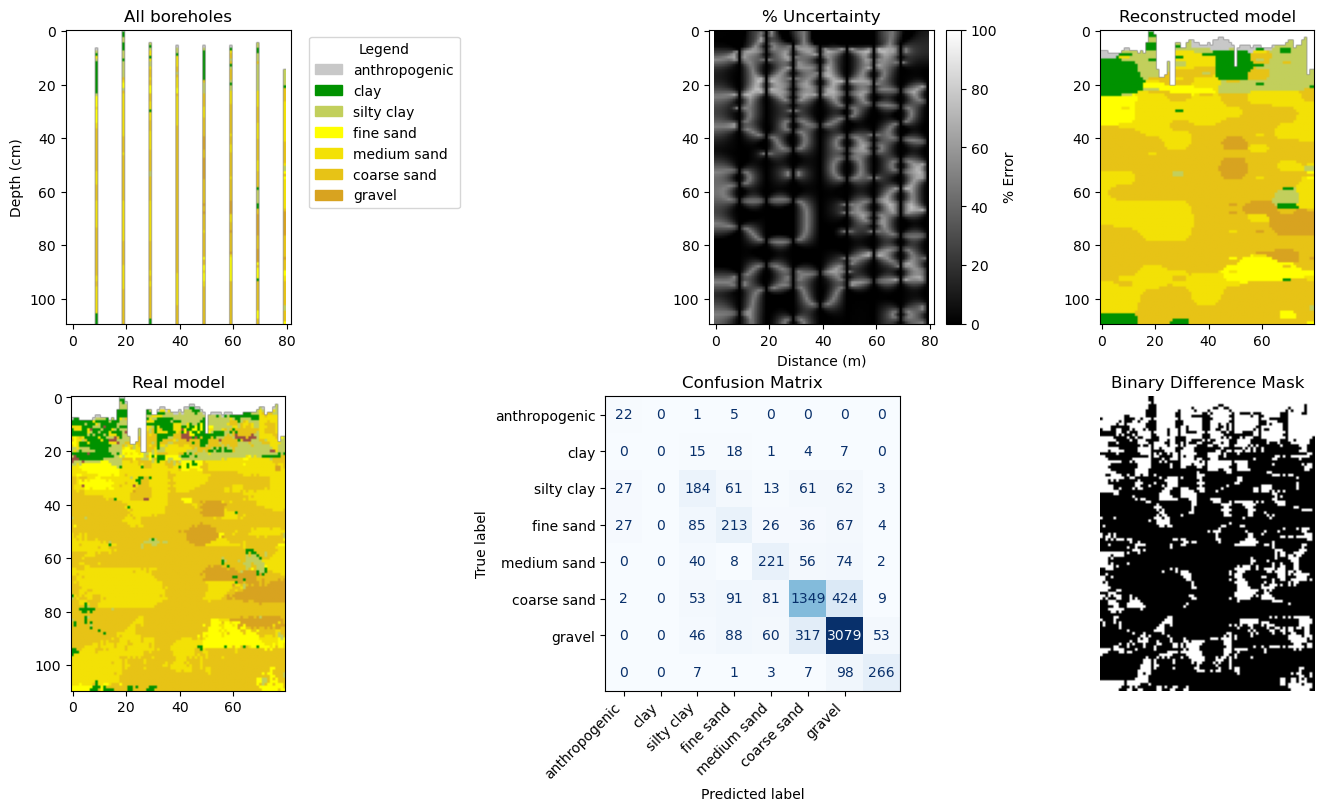

In [ ]:
basis = demo.copy()

# Ensure random_indices are within valid column range
valid_indices = random_indices[random_indices < basis.shape[1]]
basis[:, valid_indices] = np.nan

del2, del_perc = one_vs_all(basis, x_weight=1, y_weight=1)

plot_model_with_validation(demo, basis, del2, del_perc, cmap=my_map, random_indices=valid_indices)


Now let's go to a real model

In [ ]:
import geopandas as gpd
import pandas as pd
data=gpd.read_file('top_layer.gpkg')
import shapely.geometry as geom

In [ ]:
data.to_csv('test.csv')

This is the profile I will project all boreholes, to make a 2D model. It could be 3D, but that's for later

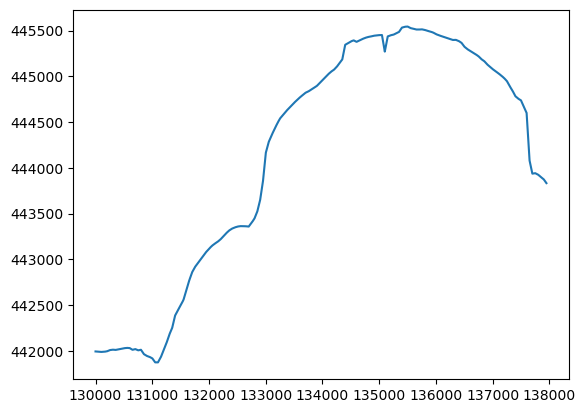

In [ ]:

coor=np.loadtxt('profile2.txt')
yn=np.interp(
    np.arange(np.min(coor[:,0]),np.max(coor[:,0]),0.5), 
    
    coor[:,0], coor[:,1])
coor=np.c_[np.arange(np.min(coor[:,0]),np.max(coor[:,0]),0.5),yn]
plt.plot(coor[:,0],coor[:,1])

C:\Users\Marios\AppData\Local\Temp\ipykernel_41096\2657338756.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Dis'].iloc[i]=tt
C:\Users\Marios\AppData\Local\Temp\ipykernel_41096\2657338756.py:8: SettingWithCopyWarning: 
A value is 

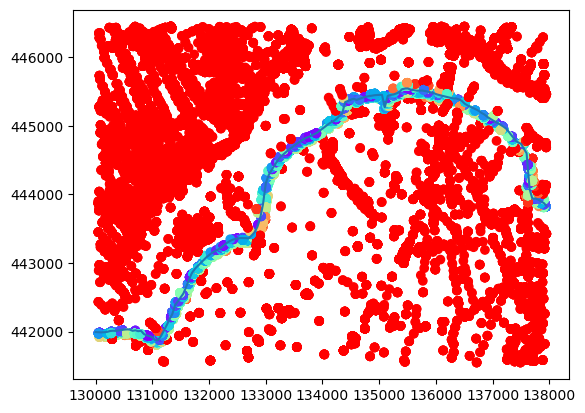

In [ ]:
line = geom.LineString(coor[:,:2])

data['Dis']=1e6

for i in range(0,len(data)):
    tt,tt2=min_distance(coor[:,0], coor[:,1], data['x'].iloc[i], data['y'].iloc[i])
    tt=tt2[np.min(tt)]
    data['Dis'].iloc[i]=tt

fig, ax = plt.subplots()
ax.scatter(data['x'], data['y'], c=data['Dis'],cmap='rainbow',vmax=100)
ax.plot(coor[:,0],coor[:,1])

In [ ]:
data['xx']=0
data['yy']=0

start_x=data['x'].min()
start_y=data['y'].min()
data['arc']=0

for i in range(0,len(data)):
    point=geom.Point(data['x'].iloc[i],data['y'].iloc[i])
    # print(point.distance(line))
    point_on_line = line.interpolate(line.project(point))

    data['xx'].iloc[i]=point_on_line.x
    data['yy'].iloc[i]=point_on_line.y
    
    data['arc'].iloc[i]=arclength(coor[:,0], coor[:,1], np.min(coor[:,0]), point_on_line.x)
    # ax.scatter(data['x'].iloc[i],data['y'].iloc[i])
    # ax.scatter(point_on_line.x,point_on_line.y)
    # ax.set_title('%.1f'%data_small['arc'].iloc[i])
    
    # plt.pause(1)    


C:\Users\Marios\AppData\Local\Temp\ipykernel_41096\1718466818.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['xx'].iloc[i]=point_on_line.x
C:\Users\Marios\AppData\Local\Temp\ipykernel_41096\1718466818.py:13: SettingWithCopyWarning

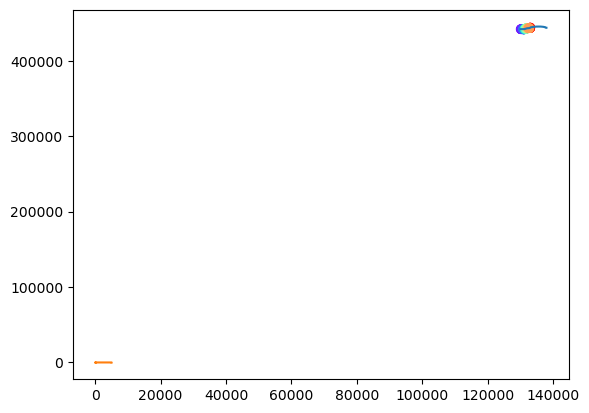

In [ ]:


data_line=data[(data['Dis']<150)  & (data['x']<133000)]
data_small=data_line.drop_duplicates(['name'],keep='first')
data_small=data_small.reset_index()

    
data_line.to_excel('data_line.xlsx')
data_small.to_excel('data_small.xlsx')
data_small=data_small.reset_index()

# data_sorted=data_small.sort_values(by=['arc'])
# plt.plot(data_sorted['arc'],data_sorted['NAP_start'],'-x')


fig, ax = plt.subplots()
ax.plot(coor[:,0],coor[:,1])
del1=data_small[data_small['NAP_start']>5]
ax.scatter(del1['x'], del1['y'],c=del1['arc'],cmap='rainbow')


# finally we will keep only on top of levee


data_final=data[data['name'].isin(del1['name'])]

data_final.to_excel('data_final.xlsx')


data_final=data_final.sort_values(by=['arc'])

plt.plot(data_final['arc'],data_final['NAP_start'])

#make 10ck intervales
data_final=data_final[data_final['GTP number'].notna()]



# make quick class for stuctures
# Assign an integer to each unique value in 'classification_for_vtk_number'
unique_classes = data_final['classification_for_VTK_number'].unique()
class_to_int = {cls: idx for idx, cls in enumerate(unique_classes)}
data_final['class_int'] = data_final['classification_for_VTK_number'].map(class_to_int)


for i in range(0,len(data_final)):
    depths=np.arange(data_final['NAP_start'].iloc[i],data_final['NAP_end'].iloc[i],-0.1)
    
    tmp=np.c_[data_final['arc'].iloc[i]*np.ones_like(depths),
              depths,
              data_final['GTP number'].iloc[i]*np.ones_like(depths),              
              data_final['class_int'].iloc[i]*np.ones_like(depths)
        ]
    
    if i==0:
        out=tmp
    else:
        out=np.r_[out,tmp]
    
    

In [ ]:



training_points=out[:,:2]
training_data=out[:,2]
training_data2=out[:,3]

int1=Geo_Gridder(training_points, training_data,method='mode')
int1.make_grid(dx=25,dy=0.5)
int1.gridder()

int1=Geo_Gridder(training_points, training_data,method='mode')
int1.make_grid(dx=25,dy=0.5)
int1.gridder()

int2=Geo_Gridder(training_points, training_data2,method='mode')
int2.make_grid(dx=25,dy=0.5)
int2.gridder()

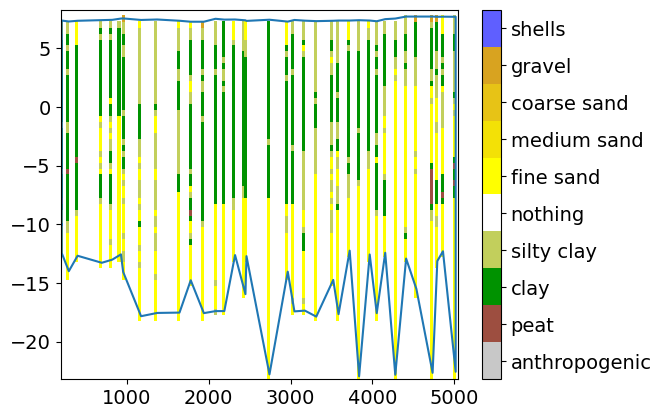

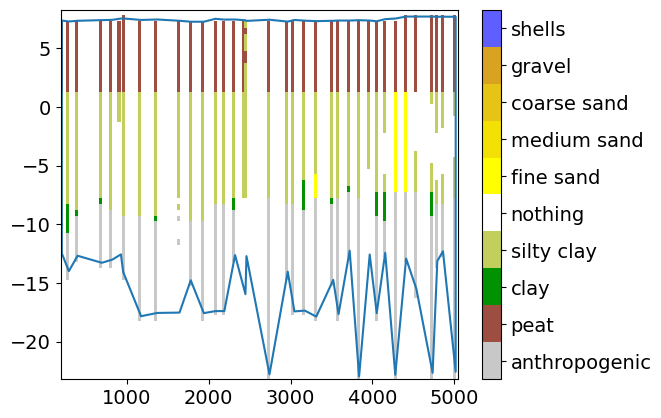

In [ ]:
#interpolate top bottom
import alphashape
from descartes import PolygonPatch

alpha_shape = alphashape.alphashape(out[:,:2], 1/150)
tt=np.array(alpha_shape.exterior.xy)
fig, ax = plt.subplots()
mat=plt.pcolor(int1.xg,int1.yg,int1.bs,vmin=0-0.5,vmax=9+0.5,cmap=my_map)

cax = plt.colorbar(mat)
cax.set_ticks(ticks=np.arange(0, 9 + 1),labels=labels)
plt.plot(tt[0,:],tt[1,:])
basis=int1.bs.copy()

col_indices = np.where(np.isfinite(basis).any(axis=0))[0]
# Exclude the first and last index
valid_indices = col_indices[1:-1]

# Calculate number of samples (20% of valid_indices)
n_samples = max(1, int(0.2 * len(valid_indices)))

# Randomly select 20% of the indices
random_indices = np.random.choice(valid_indices, size=n_samples, replace=False)

valid_indices = col_indices[1:-1]
# Select every 5th index from valid_indices only (first and last NOT included)
random_indices = valid_indices[::5]
#random_indices[-1] = 168
basis_inpaint= basis.copy()
basis_inpaint[:, random_indices] = np.nan  # Set the selected indices to NaN    



fig, ax = plt.subplots()
mat2=plt.pcolor(int2.xg,int2.yg,int2.bs,vmin=0-0.5,vmax=9+0.5,cmap=my_map)

cax = plt.colorbar(mat2)
cax.set_ticks(ticks=np.arange(0, 9 + 1),labels=labels)
plt.plot(tt[0,:],tt[1,:])
basis2=int2.bs.copy()

basis_inpaint2= basis2.copy()
basis_inpaint2[:, random_indices] = np.nan  # Set the selected indices to NaN    




In [ ]:
np.save('random_indices_best', random_indices)

In [ ]:

del2,del_perc = one_vs_all(basis_inpaint, x_weight=1, y_weight=2)
del22,del_perc = one_vs_all(basis_inpaint2 , x_weight=1, y_weight=2)






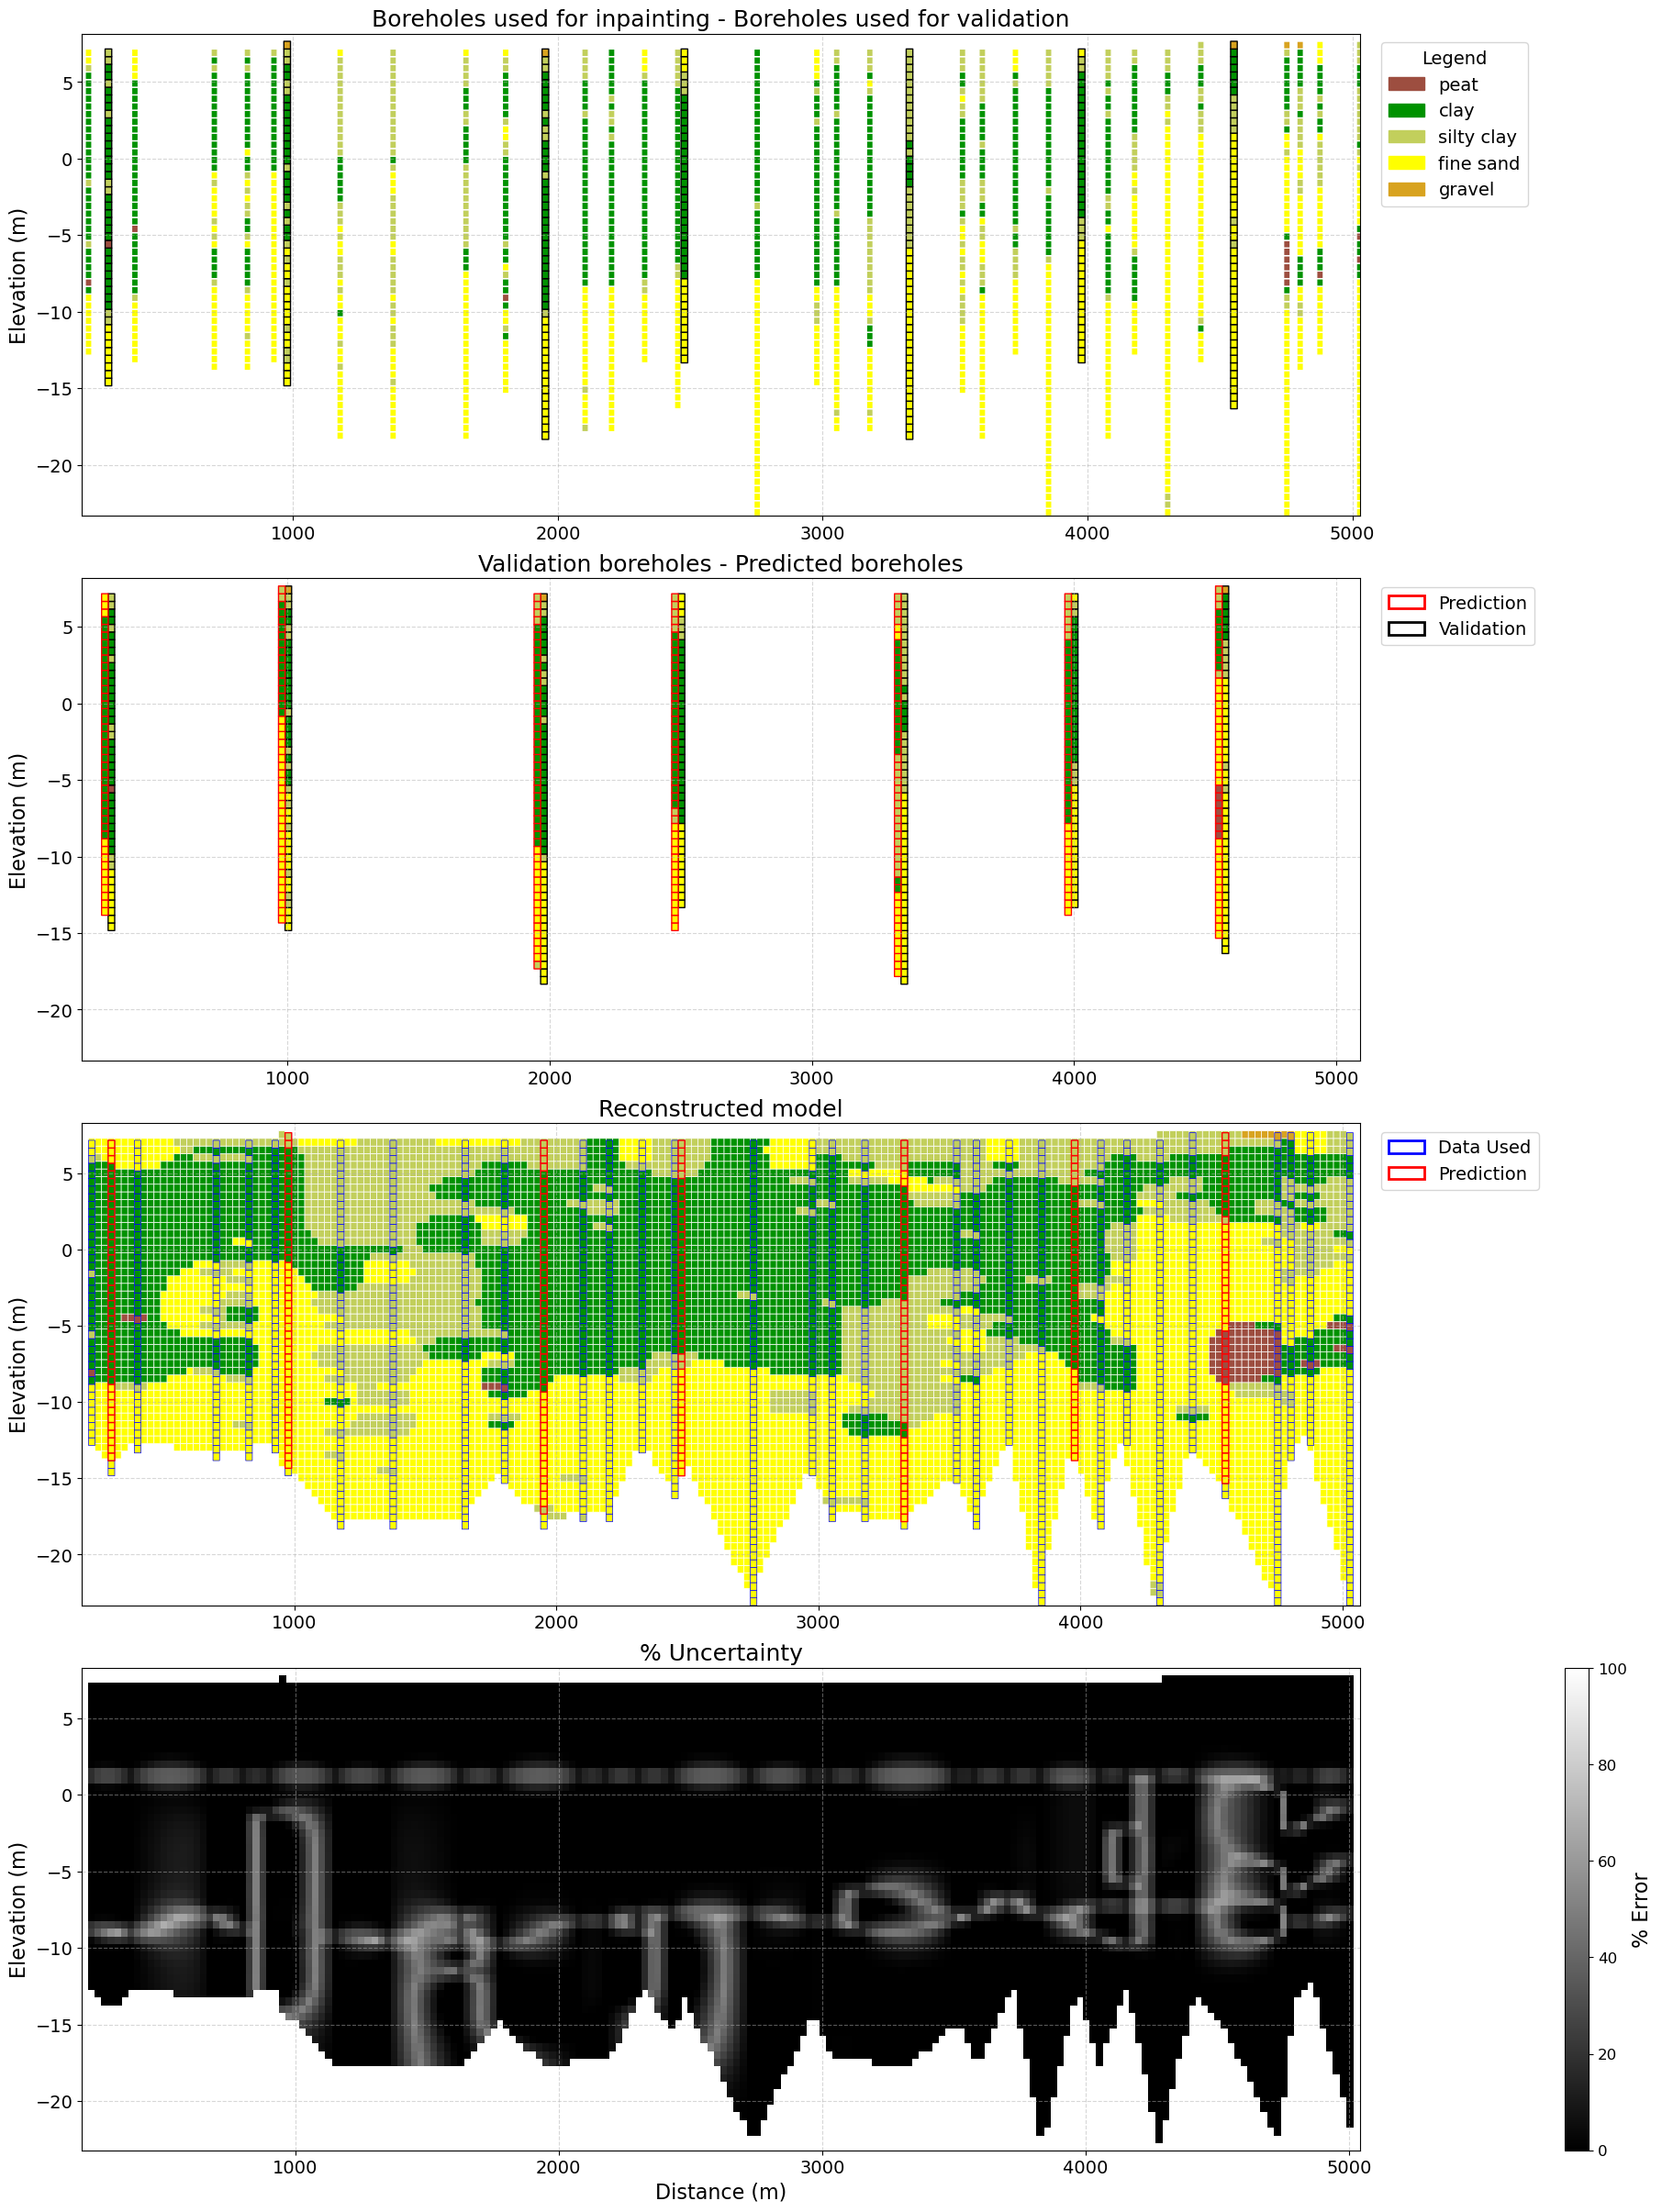

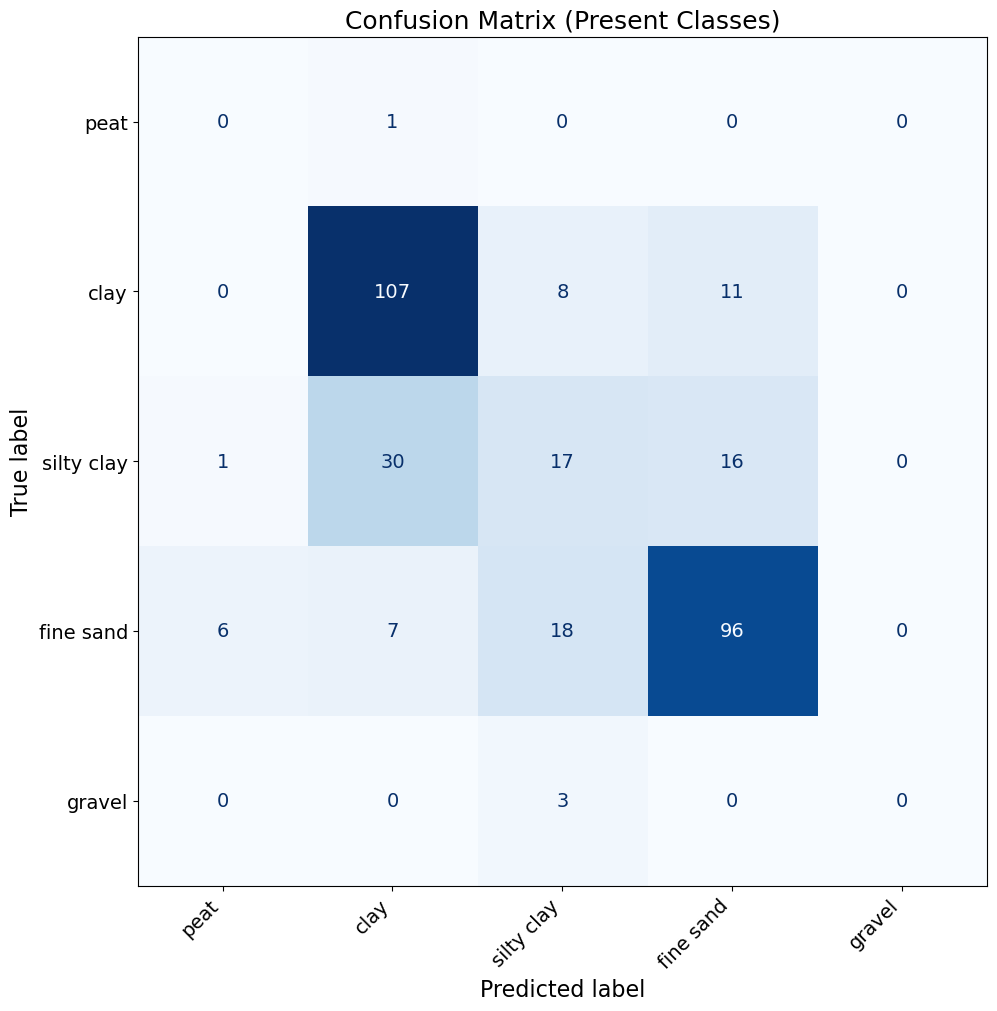

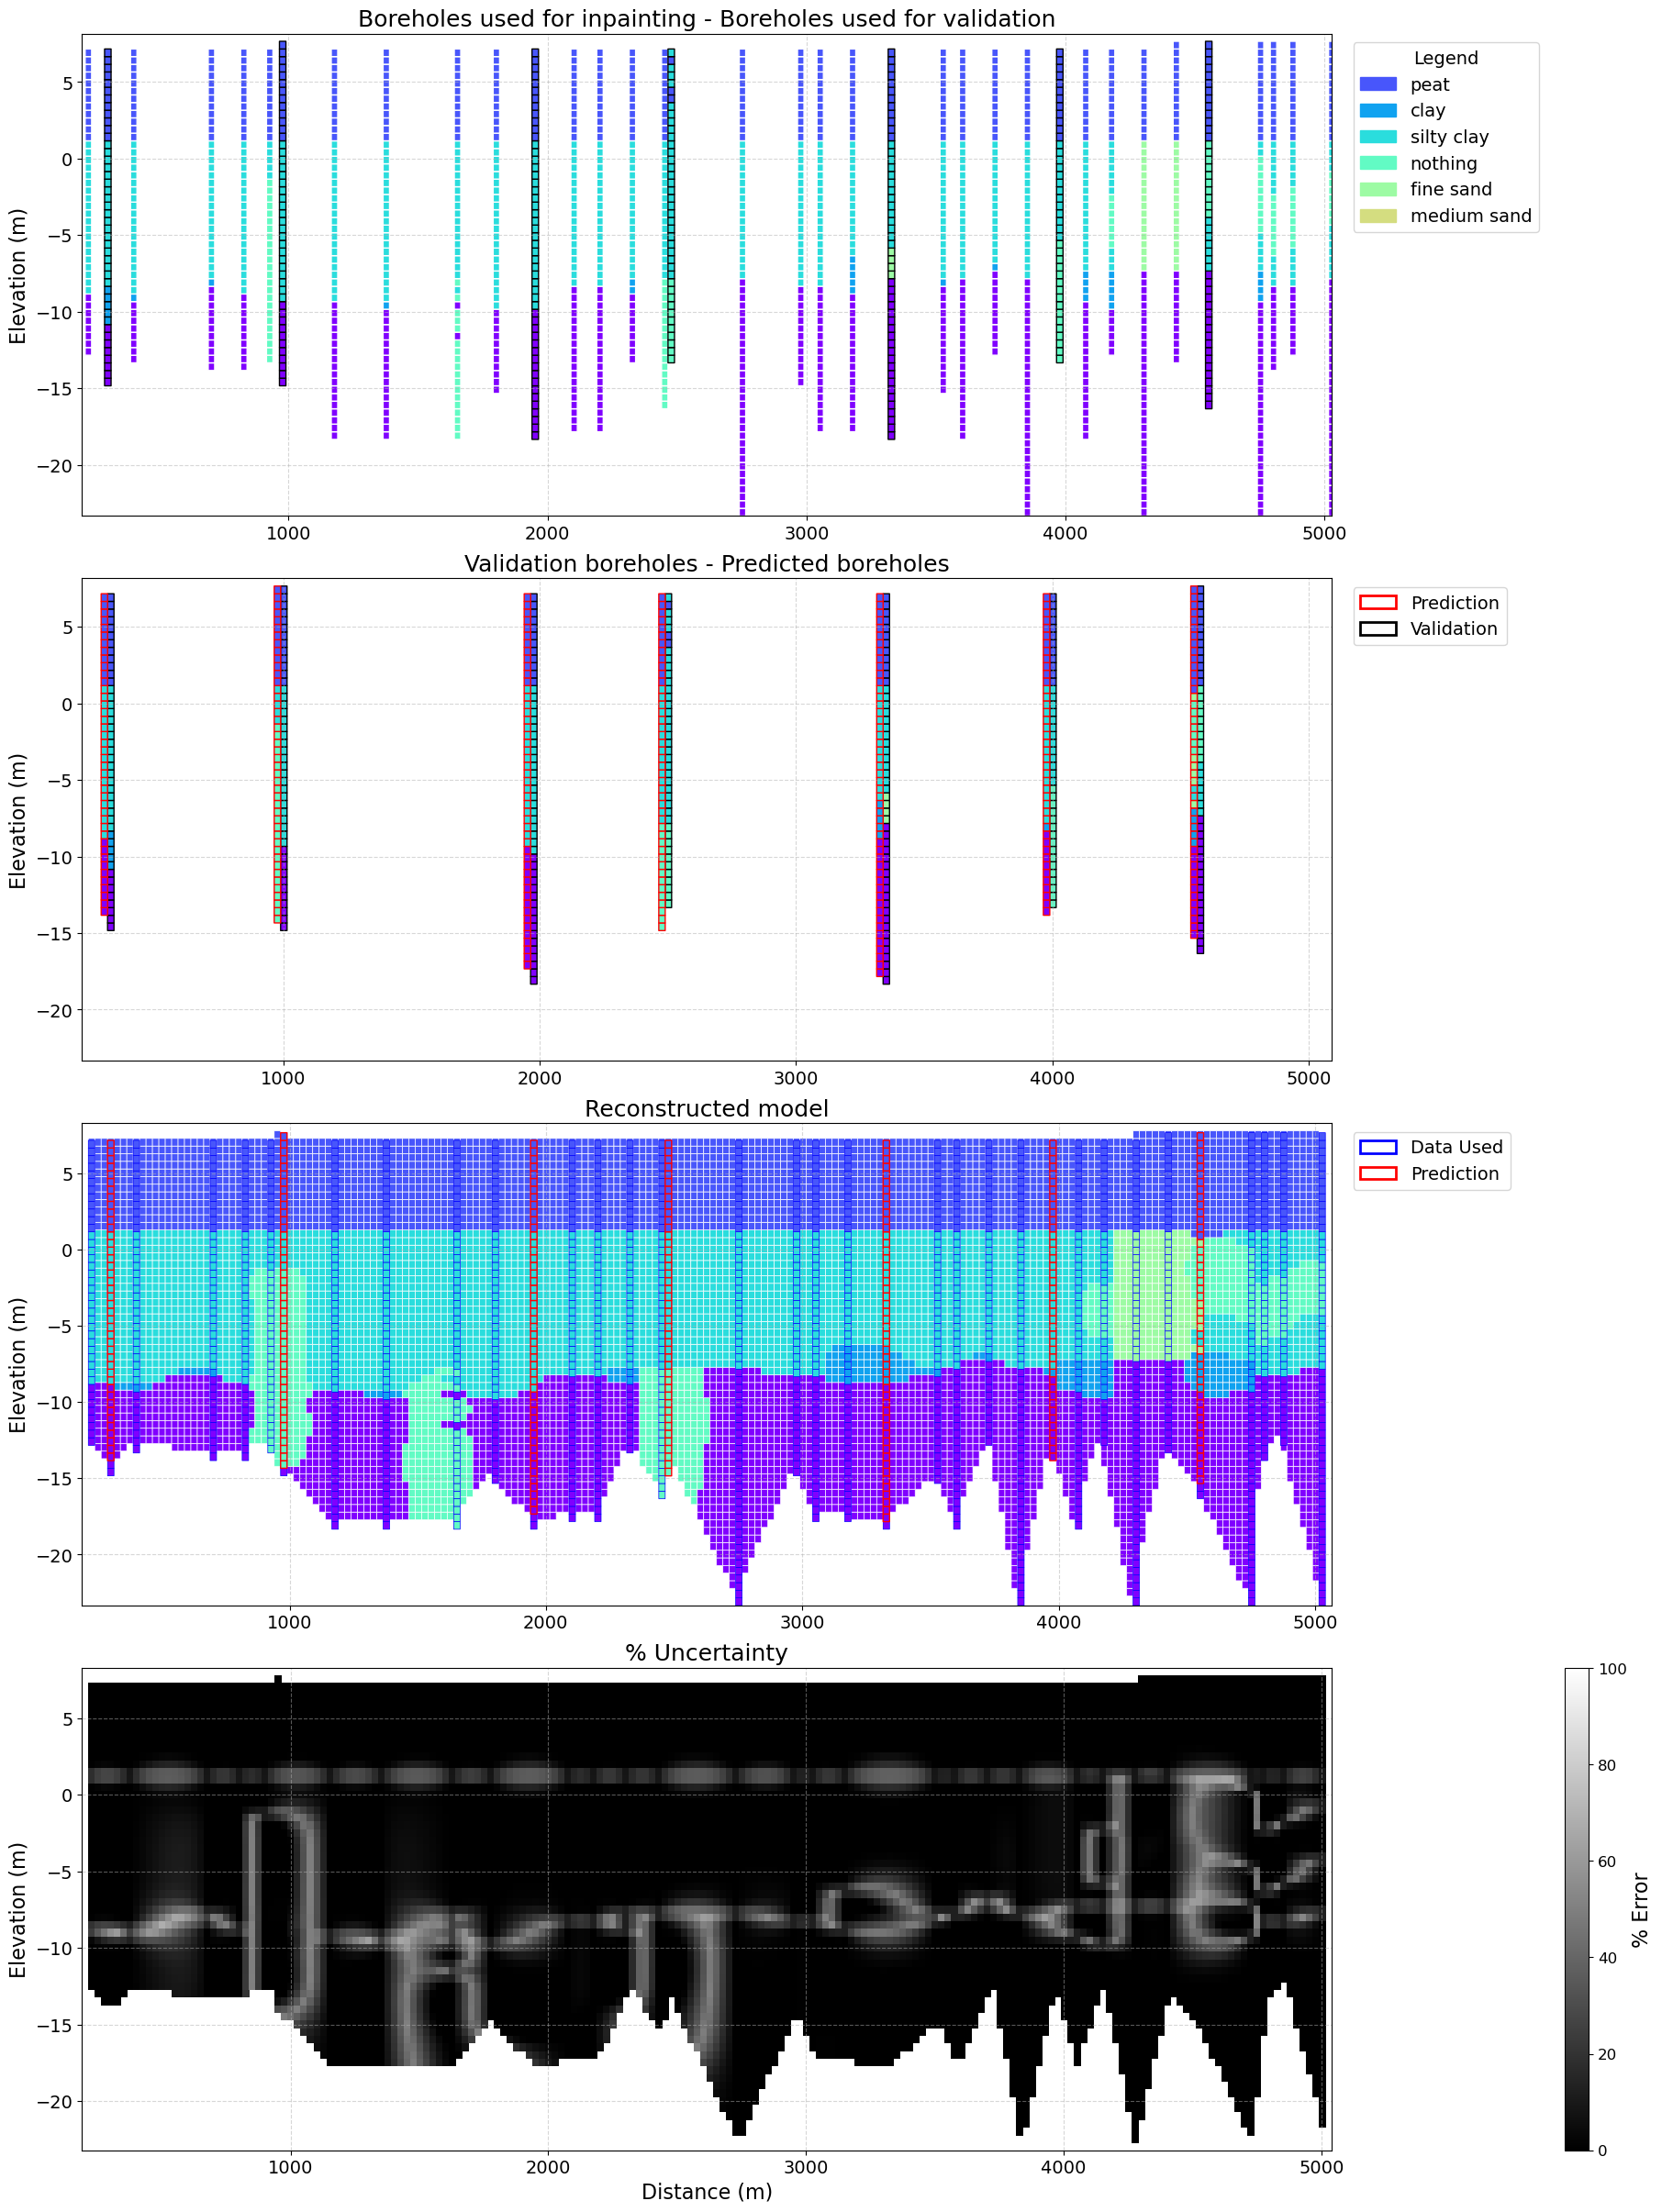

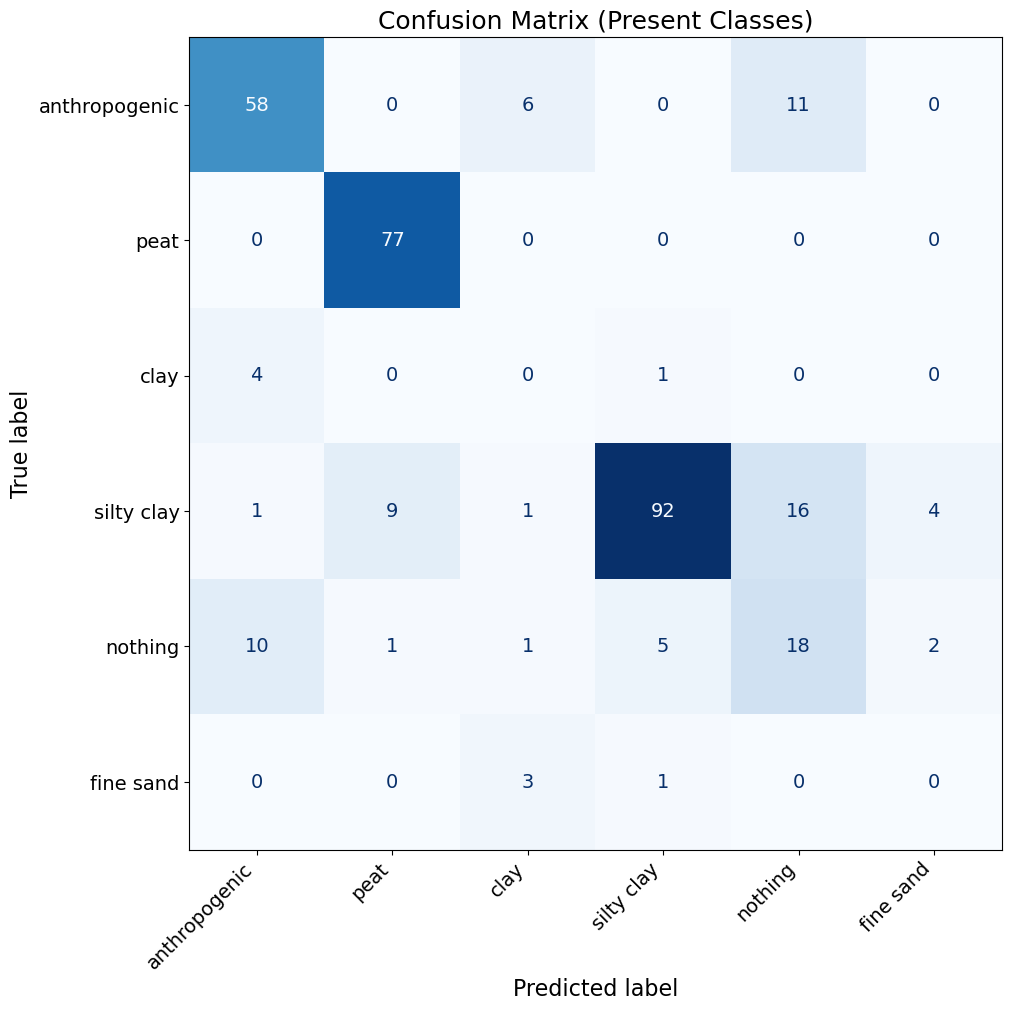

In [ ]:
plot_model_with_validation_real(int1.bs, basis_inpaint, del2, int1.xg,int1.yg,tt,del_perc, cmap=my_map, random_indices=random_indices,filename='model_with_validation_real1.pdf') 

plot_model_with_validation_real(int2.bs, basis_inpaint2+1, del22, int2.xg,int2.yg,tt,del_perc, cmap='rainbow', random_indices=random_indices,filename='model_with_validation_real2.pdf') 


let's generate a 3D example and we are done

In [ ]:
stop

NameError: name 'stop' is not defined

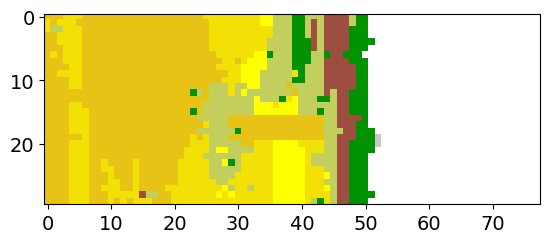

In [ ]:
geotop = np.load('geotop.npy')


top = np.zeros((geotop.shape[0]*geotop.shape[1]))
n = 0
for i in range(0, geotop.shape[0]):
    for j in range(0, geotop.shape[1]):
        ix = np.where(np.isnan(geotop[i, j, :]))[0][0]
        top[n] = ix
        n += 1

geotop=geotop[:,:,:np.max(top).astype('int32')]    

geotop=geotop[20:50,30:60,50:]
# To visualize a single slice, e.g., the 20th slice:
i=20
plt.imshow(geotop[i,:,:], cmap=my_map, vmin=0, vmax=9)



#slicd it






So we have 50x80 boreholes we would like to play with

In [ ]:
nx, ny = geotop.shape[0], geotop.shape[1]
total_points = nx * ny
n_select = int(0.95 * total_points)  # 20% of all points

# Generate all possible (row, col) index pairs
all_indices = np.array([(i, j) for i in range(nx) for j in range(ny)])

# Randomly select 20% of the indices without replacement
selected_indices = all_indices[np.random.choice(total_points, n_select, replace=False)]


not_selected_indices=np.load('not_selected_indices_95.npy')
selected_indices=np.load('selected_indices_95.npy')
not_rows, not_cols = not_selected_indices[:, 0], not_selected_indices[:, 1]

# If you want to split into row and col arrays:
rows, cols = selected_indices[:, 0], selected_indices[:, 1]

# Find the indices that were NOT selected
not_selected_mask = np.ones(total_points, dtype=bool)
not_selected_mask[np.unique(np.ravel_multi_index(selected_indices.T, (nx, ny)))] = False
not_selected_indices = all_indices[~not_selected_mask]

# Split into row and col arrays for non-selected indices
not_rows, not_cols = not_selected_indices[:, 0], not_selected_indices[:, 1]

In [ ]:
#np.save('selected_indices_95', )
#np.save('not_selected_indices_95', not_selected_indices)





In [ ]:
geoptop_inpaint = geotop.copy()
for r, c in zip(rows, cols):
    geoptop_inpaint[r, c, :] = np.nan

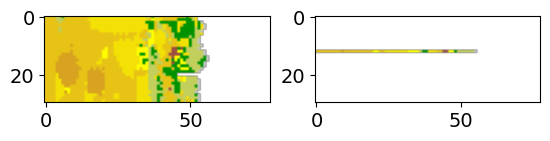

In [ ]:
i=0
plt.subplot(1, 2, 1)
plt.imshow(geotop[i, :, :], cmap=my_map, vmin=0, vmax=9)
plt.subplot(1, 2, 2)
plt.imshow(geoptop_inpaint[i, :, :], cmap=my_map, vmin=0, vmax=9)


In [ ]:
int1=VtkClass()
xc= np.arange(0, 100*geotop.shape[0],100)
yc= np.arange(0, 100*geotop.shape[1],100)
zc= np.arange(0, 0.5*geotop.shape[2]+0.5,0.5)





In [ ]:
#int1.make_3d_grid_to_vtk('geotop.vtk',np.transpose(geotop, (1, 0, 2)),xc,yc,zc)
#int1.make_3d_grid_to_vtk('geotop_to_inpaint_95.vtk',np.transpose(geoptop_inpaint, (1, 0, 2)),xc,yc,zc)

In [ ]:
del1,del_perc = one_vs_all_3d(geoptop_inpaint.copy(), x_weight=1, y_weight=1, z_weight=1)

: 

: 

In [ ]:
del1[np.isnan(geotop)]=np.nan
del_perc[np.isnan(geotop)]=np.nan
#int1.make_3d_grid_to_vtk('geotop_inpainted_95.vtk',np.transpose(del1, (1, 0, 2)),xc,yc,zc)
i#nt1.make_3d_grid_to_vtk('geotop_inpainted2_del_perc_95.vtk',np.transpose(del_perc, (1, 0, 2)),xc,yc,zc)

In [ ]:
# Select all values from the 3rd dimension of geotop at (not_rows, not_cols)
true_label = geotop[not_rows, not_cols, :].ravel()
pred_label = del1[not_rows, not_cols, :].ravel()

mask = np.isfinite(true_label) & np.isfinite(pred_label)
true_label_finite = true_label[mask]
pred_label_finite = pred_label[mask]

In [ ]:
plot_confusion_matrix(true_label_finite, pred_label_finite, labels=labels, title='Confusion Matrix for 3D Inpainting', cmap=plt.cm.Blues)

NameError: name 'true_label_finite' is not defined